In [1]:
import json
import requests

## Question 1. Running Elastic

The version.build_hash value is  **"42f05b9372a9a4a470db3b52817899b99a76ee73"**


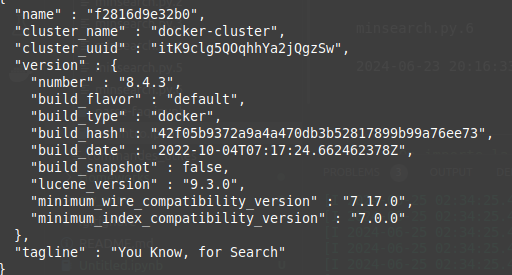

## Getting the data

In [2]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

## Question 2. Indexing the data

The function which use for adding data to elastic is the function : **index**

## Question 3. Searching

In [ ]:
key = "gsk_******"

In [4]:
import os

from groq import Groq

client = Groq(
    api_key=os.environ.get(key),
)

In [5]:
from elasticsearch import Elasticsearch

In [6]:
es_client = Elasticsearch('http://localhost:9200') 

In [7]:


index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = "homework1-questions"

es_client.indices.create(index=index_name, body=index_settings)



ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'homework1-questions'})

In [8]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

In [9]:
from tqdm.auto import tqdm

In [10]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

In [11]:
query = 'How do I execute a command in a running docker container?'

In [12]:
def elastic_search(query):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^4", "text"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    hit_score = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
        hit_score.append(hit["_score"])
    
    return result_docs, hit_score



In [13]:
result_docs, hit_score = elastic_search(query)
hit_score

[75.54128, 43.922554, 38.684105, 38.33403, 35.94081]

The score for the top ranking result is **74.05**

## Question 4. Filtering

In [14]:
def elastic_search(query):
    search_query = {
        "size": 3,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^4", "text"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "machine-learning-zoomcamp"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    hit_score = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
        hit_score.append(hit["_score"])
    
    return result_docs, hit_score



In [21]:
result_docs, hit_score = elastic_search(query)
result_docs[2]["question"]

'How do I copy files from a different folder into docker container’s working directory?'

The 3rd question returned by the search engine is **How do I copy files from a different folder into docker container’s working directory?**

## Question 5. Building a prompt

In [48]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""

    
    
    for doc in search_results:
        context = context + f"question: {doc['question']}\nanswer: {doc['text']}\n\n"
        
    print("Résultats :", context)
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [50]:
prompt = build_prompt(query, result_docs)
len(prompt)

Résultats : question: How do I debug a docker container?
answer: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.
docker run -it --entrypoint bash <image>
If the container is already running, execute a command in the specific container:
docker ps (find the container-id)
docker exec -it <container-id> bash
(Marcos MJD)

question: How do I copy files from my local machine to docker container?
answer: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:
To copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:
docker cp /path/to/local/file_or_directory container_id:/path/in/container
Hrithik Kumar Advani

question: How do I copy files from a different folder into docker container’s working directory?
answer: You can copy files from your local machine into a Docker conta

1499

## Question 6 : Tokens

In [51]:
response = client.chat.completions.create(
    model="llama3-8b-8192",
    messages=[{"role": "user", "content": prompt}]
    )

In [52]:
response_dict = response.to_dict()
tokens = response_dict["usage"]["prompt_tokens"]
tokens

335

## Bonus: generating the answer

In [53]:
print(response.choices[0].message.content)

Based on the provided CONTEXT, the QUESTION "How do I execute a command in a running docker container?" can be answered as:

"If the container is already running, execute a command in the specific container:"

docker ps (find the container-id)
docker exec -it <container-id> bash

This answer is directly taken from the FAQ database, which suggests that one can execute a command in a running docker container by first finding the container-id using the `docker ps` command and then using the `docker exec` command to execute a command in that container.
